## Описание проекта

В отделе маркетинговой аналитики Яндекс.Афиши необходимо помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Необходимо изучить:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

## Шаг 1. Открытие файла и изучение информации

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Напишем функцию которая будет выводин информацию о данных

In [3]:
def information(table):
    display(table.sample(5))
    print()
    print(table.info())
    #print()
    #print(table.isna().sum())
    print()
    print('Количество дубликатов:', table.duplicated().sum())

In [4]:
information(visits)
information(orders)
information(costs) 

,Device,End Ts,Source Id,Start Ts,Uid
117598,desktop,2018-01-22 14:41:00,2,2018-01-22 14:39:00,6001763211313483842
147048,desktop,2018-05-29 18:09:00,1,2018-05-29 18:09:00,16463926135120139753
105011,touch,2018-02-07 17:23:00,1,2018-02-07 17:06:00,10141232741313299117
170088,touch,2017-09-08 22:02:00,9,2017-09-08 22:02:00,10428625409164331655
353042,touch,2018-05-13 12:13:00,5,2018-05-13 12:13:00,702806201153460110



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

Количество дубликатов: 0


,Buy Ts,Revenue,Uid
26800,2017-12-28 21:06:00,2.22,13370304157520529243
33952,2018-02-10 13:32:00,4.67,1951687038074646413
7020,2017-09-06 18:28:00,0.73,221205700650450525
34182,2018-02-11 16:28:00,16.50,5539673724080479777
49227,2018-05-28 06:35:00,22.00,15671778172031370868



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

Количество дубликатов: 0


,source_id,dt,costs
489,2,2017-10-05,145.18
152,1,2017-10-31,72.94
49,1,2017-07-20,28.46
2290,10,2017-09-20,18.89
2385,10,2017-12-24,12.72



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

Количество дубликатов: 0


Таблица **visits** (лог сервера с информацией о посещениях сайта):
* Device — категория устройства пользователя;
* End Ts — дата и время окончания сессии;
* Source Id — id рекламного источника, из которого пришел пользователь;
* Start Ts — дата и время начала сессии;
* Uid — уникальный идентификатор пользователя.

Таблица **orders** (информация о заказах):
* Buy Ts — дата и время заказа;
* Revenue — сумма заказа (выручка);
* Uid — уникальный идентификатор пользователя.

Таблица **costs** (информация о расходах на маркетинг):
* Source_id — идентификатор рекламного источника;
* dt — дата проведения рекламной компании;
* costs — затраты на этот рекламный источник в этот день.

**Вывод**. 
Для последующей работы с данными необходимо привести названия столбцов к нижнему регистру и заменить пробелы. Привести столбцы с датой и временем к соответстующим типам.

## Шаг 2. Предобработка данных

### Замена названия столбцов

Напишем функцию, которая переведет столбцы к нижнему регистру и заменит пробелы на "_" 

In [5]:
def change_columns(table):
    list_of_columns = []
    for column in table.columns:
        column = column.lower()
        column = column.replace(' ', '_')
        list_of_columns.append(column)
    table.columns = list_of_columns
    return table

In [6]:
display(change_columns(visits).head(2))
display(change_columns(orders).head(2))
display(change_columns(costs).head(2))

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


### Преобразование данных в нужные типы

In [7]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [8]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [9]:
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## Шаг 3. Расчет метрик и посторение графиков

### Продуктовые метрики

#### Расчет DAU, WAU и MAU. 

In [10]:
visits.head(3)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


Чтобы посчитать дневное,недельное и месячное использование, выведем в отдельных столбцах год, месяц и неделю, а также полную дату.

In [11]:
visits['date'] = visits['start_ts'].dt.date
visits['day'] = visits['start_ts'].dt.day
visits['week'] = pd.DatetimeIndex(visits['start_ts']).week
visits['month'] = pd.DatetimeIndex(visits['start_ts']).month
visits['year'] = pd.DatetimeIndex(visits['start_ts']).year

In [12]:
visits.head(2)

,device,end_ts,source_id,start_ts,uid,date,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,8,2,2018


Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее

In [13]:
dau_total = visits.groupby(['date']).agg({'uid':'nunique'}).mean()
wau_total = visits.groupby(['year', 'week']).agg({'uid':'nunique'}).mean()
mau_total = visits.groupby(['year', 'month']).agg({'uid':'nunique'}).mean()
print('В день сервисом в среднем пользуются:', int(dau_total))
print('В неделю сервисом в среднем пользуются:', int(wau_total))
print('В месяц сервисом в среднем пользуются:', int(mau_total))

В день сервисом в среднем пользуются: 907
В неделю сервисом в среднем пользуются: 5716
В месяц сервисом в среднем пользуются: 23228


#### Отображение измениения метрик во времени на графике 

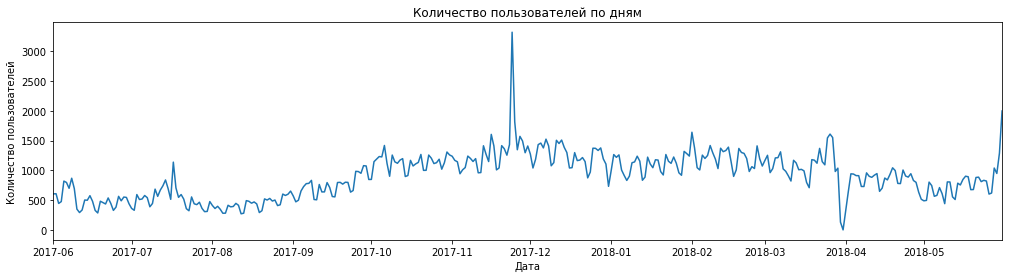

In [14]:
visits.groupby(['date']).agg({'uid':'nunique'}).plot(figsize = (17,4), 
                                                     title = 'Количество пользователей по дням',
                                                    legend=None)
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

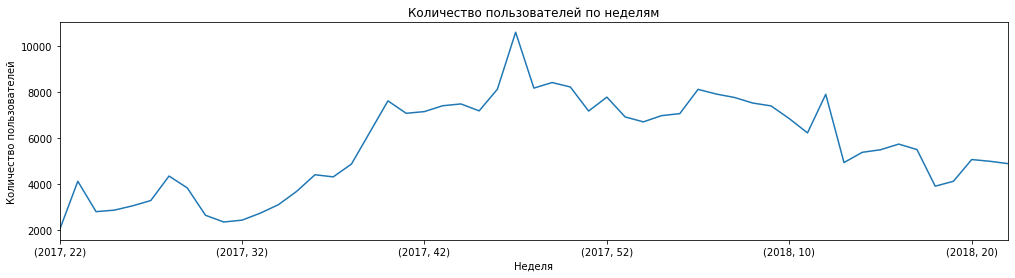

In [15]:
visits.groupby(['year', 'week']).agg({'uid':'nunique'}).plot(figsize = (17,4), 
                                                     title = 'Количество пользователей по неделям',
                                                            legend=None)
plt.xlabel('Неделя')
plt.ylabel('Количество пользователей')
plt.show()

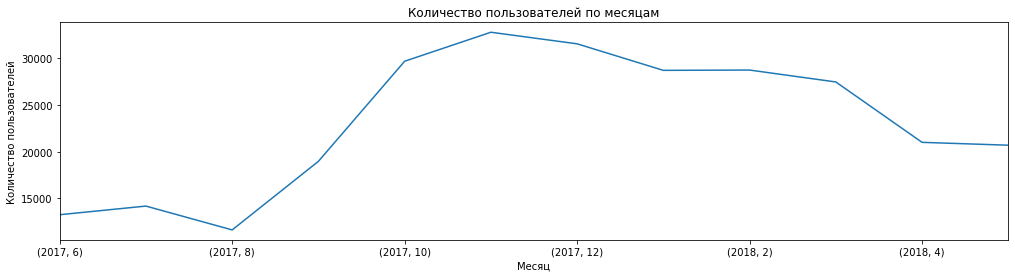

In [16]:
visits.groupby(['year', 'month']).agg({'uid':'nunique'}).plot(figsize = (17,4), 
                                                     title = 'Количество пользователей по месяцам',
                                                             legend=None)
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.show()

In [17]:
visits.groupby(['year', 'month']).agg({'uid':'nunique'})

uid
year month       
2017 6      13259
     7      14183
     8      11631
     9      18975
     10     29692
     11     32797
     12     31557
2018 1      28716
     2      28749
     3      27473
     4      21008
     5      20701

**Вывод.** Из графиков видно, что каждые 7 дней количество уникальных пользователей взлетает и снова падает. Большое количество уникальных пользователей наблюдается с октября 2017 года по март 2018 года. Пик приходится на декабрь. Скорее всего это связанно с тем что заканчивается дачный и летний сезон и посетитель все чаще обращаются на сайт в поиске как провести свой досуг

#### Определение сколько раз в день пользователи заходят на сайт

Посчитаем sticky factor («липкий фактор») — то, как часто пользователи к нему обращаются.


In [18]:
sticky_wau = dau_total / wau_total
sticky_mau = dau_total / mau_total
print('Регулярность использования аудиторией в неделю: {:.2%}'.format(sticky_wau[0]))
print('Регулярность использования аудиторией в месяц: {:.2%}'.format(sticky_mau[0]))

Регулярность использования аудиторией в неделю: 15.88%
Регулярность использования аудиторией в месяц: 3.91%


Вовлеченность аудитории не высокая. Посчитаем сколько сессий в день происходит в среднем на сайте

In [19]:
day_visits = visits.groupby(['date']).agg({'uid':'count'})
#day_visits
print('В среднем в день на сайт заходят раз:', int(day_visits['uid'].mean()))

В среднем в день на сайт заходят раз: 987


#### Расчет времени, которое пользователи проводят на сайте

Вычислим сколько секунд в среднем длиться каждая сессия

In [20]:
visits['second'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Выведем все ссесии не нулевые и построим гистограмму

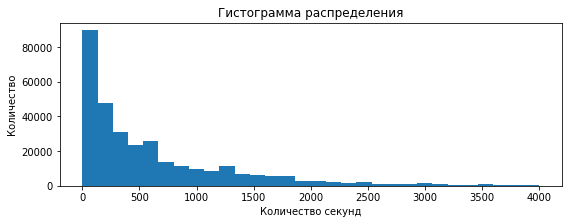

In [21]:
durations_visits = visits[visits['second'] != 0]['second']
durations_visits.plot(kind = 'hist', bins = 30, figsize = (9,3), range = (0, 4000))

plt.title ('Гистограмма распределения')
plt.xlabel('Количество секунд')
plt.ylabel('Количество')
plt.show()

Распределение длительности не выглядит как нормальное, поэтому будем искать моду (значение, встречающееся чаще всего), а не среднее

In [22]:
durations_visits.mode()

0    60
dtype: int64

Одна типичная пользовательская сессия за весь период длится в среднем 1 минуту

In [23]:
durations_visits.describe()

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: second, dtype: float64

Вычислим количество сесий, количество пользователей, количество сесий на одного пользователя и количество сесий на день по месяцам

In [24]:
sessions_per_user = visits.groupby(['year', 'month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['count_sessions', 'count_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['count_sessions'] / sessions_per_user['count_users']).round(2)
sessions_per_user['count_sessions_per_day'] = (sessions_per_user['count_sessions'] / 30).round()
sessions_per_user

count_sessions  count_users  sessions_per_user  \
year month                                                   
2017 6               16505        13259               1.24   
     7               17828        14183               1.26   
     8               14355        11631               1.23   
     9               23907        18975               1.26   
     10              37903        29692               1.28   
     11              43969        32797               1.34   
     12              41983        31557               1.33   
2018 1               36939        28716               1.29   
     2               37182        28749               1.29   
     3               35679        27473               1.30   
     4               26515        21008               1.26   
     5               26635        20701               1.29   

            count_sessions_per_day  
year month                          
2017 6                       550.0  
     7                       594.0  
     8                       478.0  
     9                       797.0  
     10                     1263.0  
     11                     1466.0  
     12                     1399.0  
2018 1                      1231.0  
     2                      1239.0  
     3                      1189.0  
     4                       884.0  
     5                       888.0

С октября 2017 года по март 2018 года наблюдаются самые высокие показатели количества сессий в день. Так же средее количество сессий на одного пользователя не превышает 1.34. Причиной этого может служить тот факт, что пользователи заходили для того, чтобы сделать заказ и проверить его, но возвращаються редко.

Найдем действительное количество сессий на пользователя за всё время.

In [25]:
sessions_per_user_new = sessions_per_user['count_sessions'].sum() / sessions_per_user['count_users'].sum()
print('Действительное количество сессий на пользователя за всё время:', sessions_per_user_new)

Действительное количество сессий на пользователя за всё время: 1.2893689841106977


Сгруппируем таблицу и найдем количество сессий в день по дням, а в следующей таблице по месяцам

In [26]:
sessions_per_user_new = visits.groupby(['year','month','day']).agg({'uid':['count', 'nunique']})
sessions_per_user_new.columns = ['count', 'count_sessions_per_day']
sessions_per_user_new['part'] = (sessions_per_user_new['count']*100 
                                 / sessions_per_user_new['count_sessions_per_day'])-100
sessions_per_user_new['part'].mean()
sessions_per_user_new

count  count_sessions_per_day       part
year month day                                          
2017 6     1      664                     605   9.752066
           2      658                     608   8.223684
           3      477                     445   7.191011
           4      510                     476   7.142857
           5      893                     820   8.902439
...               ...                     ...        ...
2018 5     27     672                     620   8.387097
           28    1156                    1039  11.260828
           29    1035                     948   9.177215
           30    1410                    1289   9.387122
           31    2256                    1997  12.969454

[364 rows x 3 columns]

Из таблицы видно что повторно на сайт возвращается около 8 процентов

In [27]:
sessions_per_user_new.groupby(['year','month']).agg({'count_sessions_per_day':'mean'}).round()
#sessions_per_user_new.groupby(['year','month']).agg({'count_sessions_per_day':'mean'}).round()['count_sessions_per_day'].mean()

count_sessions_per_day
year month                        
2017 6                       511.0
     7                       532.0
     8                       433.0
     9                       739.0
     10                     1133.0
     11                     1329.0
     12                     1241.0
2018 1                      1097.0
     2                      1217.0
     3                      1053.0
     4                       846.0
     5                       786.0

**Вывод**
- В среднем в день на сайт заходят 987 раз. 
- Далее было выявлено что в среднем каждый пользователь заходит на ресурс лишь 1 раз в день. Количество сессий на одного пользователя не превышает 1.34.
- Продолжительность большей части сессий - около 1 минуты. Фактически, пользователи заходят на сайт и сразу с него уходят.

#### Расчет Retention Rate (сколько пользователей возвращается)

Ранее было выявлено, что средее количество сессий на одного пользователя не превышает 1.3. Видим, что сервисом пользуются редко. Пользователи заходят для того, чтобы сделать заказ и проверить его.

Расчитаем Retention Rate, чтобы посмотреть как часто возвращаются пользователи, применяя когортный анализ.
Найдем первую активность пользователей и добавим в исходную таблицу visits

In [28]:
first_date = visits.groupby('uid')['start_ts'].min()
first_date.name = 'first_date'
visits_new = visits.join(first_date, on='uid')
visits_new.head(5)

,device,end_ts,source_id,start_ts,uid,date,day,week,month,year,second,first_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,51,12,2017,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,8,2,2018,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,26,7,2017,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,20,5,2018,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,52,12,2017,0,2017-12-27 14:06:00


Cоздадим новый датафрейм чтобы не видеть не нужные столбцы

In [29]:
visits_new = visits_new[['uid', 'first_date', 'start_ts']]
visits_new['first_month'] = visits_new['first_date'].astype('datetime64[M]')
visits_new['start_month'] = visits_new['start_ts'].astype('datetime64[M]')
visits_new['lifetime'] = visits_new['start_month'] - visits_new['first_month']
visits_new['lifetime'] = visits_new['lifetime'] / np.timedelta64(1, 'M')
visits_new['lifetime'] = visits_new['lifetime'].round().astype('int')
visits_new.head(5)

,uid,first_date,start_ts,first_month,start_month,lifetime
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,16174680259334210214,2018-03-09 20:05:00,2018-05-20 10:59:00,2018-03-01,2018-05-01,2
4,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»

In [30]:
cohorts_visits = (visits_new.groupby(['first_month', 'lifetime'])
                  .agg({'uid':'nunique'})).reset_index()
cohorts_visits.head(5)

,first_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц.
Найдём исходное количество пользователей в когорте. Возьмём их число за первую сессию

In [31]:
initial_users_count = cohorts_visits[cohorts_visits['lifetime'] == 0][['first_month', 'uid']]
initial_users_count.columns = ['first_month', 'cohort_users']
initial_users_count = initial_users_count.set_index('first_month')
initial_users_count

,cohort_users
first_month,
2017-06-01,13259
2017-07-01,13140
2017-08-01,10181
2017-09-01,16704
2017-10-01,25977
2017-11-01,27248
2017-12-01,25268
2018-01-01,22624
2018-02-01,22197


Объединим данные по когортам с исходным количеством пользователей в когорте:

In [32]:
#cohorts_visits = cohorts_visits.join(initial_users_count, on = 'first_month')
cohorts_visits = cohorts_visits.merge(initial_users_count,on='first_month')
cohorts_visits

,first_month,lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из месяцев на исходное число пользователей в когорте:

In [33]:
cohorts_visits['retention'] = cohorts_visits['uid'] / cohorts_visits['cohort_users']

Построим сводную таблицу и создадим тепловую карту:

In [34]:
retention_pivot = cohorts_visits.pivot_table(
    index='first_month',
    columns='lifetime',
    values='retention',
    aggfunc='sum')
retention_pivot = retention_pivot.reset_index()
retention_pivot['first_month'] = retention_pivot['first_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_month')
#retention_pivot = retention_pivot.fillna(0)
#retention_pivot['mean'] = retention_pivot.mean(axis=1)
retention_pivot.loc['mean'] = retention_pivot.mean()
#retention_pivot = retention_pivot.round(4)
retention_pivot


lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


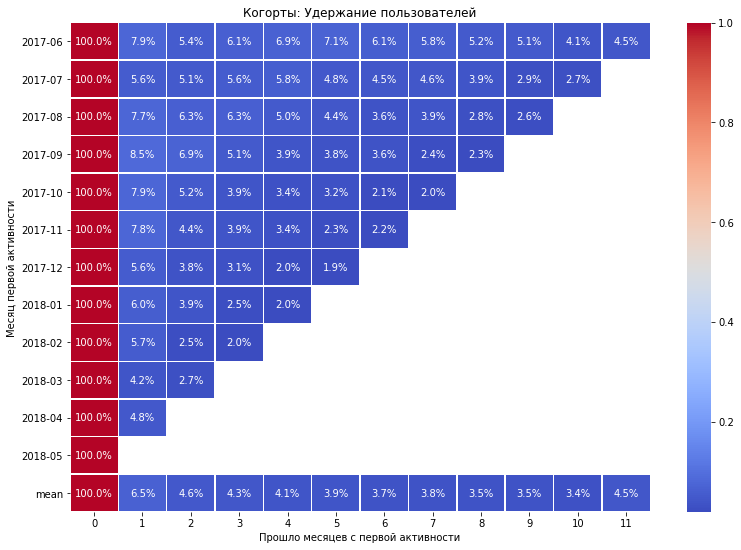

In [35]:
plt.figure(figsize=(13, 9))
plt.title('Когорты: Удержание пользователей')
sns.heatmap(retention_pivot, annot=True, fmt=".1%", linewidths=.5, cmap = 'coolwarm')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show(); 


Как мы видим, возвращаются пользователи редко. Не больше 8ми процентов. Retention второго месяца пользования нашим ресурсом находится в интервале от 4,2 до 8,5% в зависимости от когорты.Причем после одного месяца пользователя, на второй, возвращается большая часть клиентов, далее, с течением времени, этот процент падает.
Это справедливо для всех, кроме самой первой когорты, которая начала пользоваться ресурсом в июне 2017 года. Их Retention тоже довольно низкий, но постоянно находится в "лидерах" по сравнении со всеми остальными когортами.

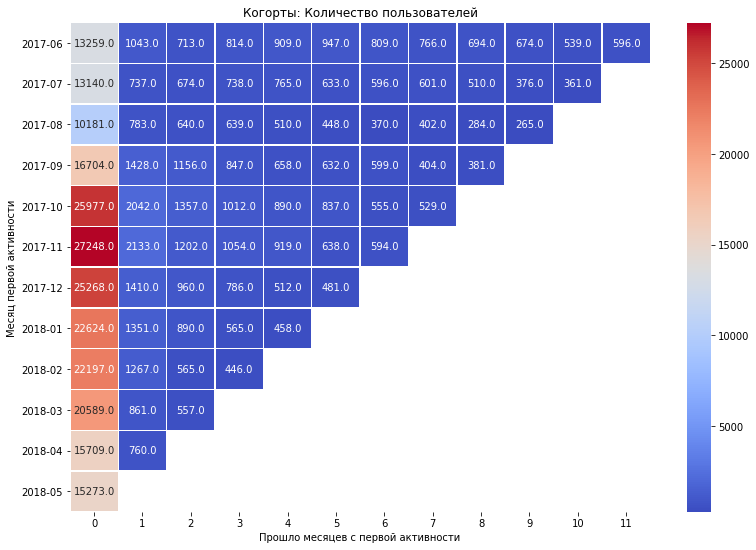

In [36]:
retention_pivot_user = cohorts_visits.pivot_table(
     index='first_month',
    columns='lifetime',
    values='uid',
    aggfunc='sum')
retention_pivot_user = retention_pivot_user.reset_index()
retention_pivot_user['first_month'] = retention_pivot_user['first_month'].dt.strftime('%Y-%m')
retention_pivot_user = retention_pivot_user.set_index('first_month')

plt.figure(figsize=(13, 9))
plt.title('Когорты: Количество пользователей')
sns.heatmap(retention_pivot_user, annot=True, fmt=".1f", linewidths=.5, cmap = 'coolwarm')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show(); 

Из тепловой карты количества активных пользователей видим, что начиная с октября средняя численность когорты серьезно возросла до 27248 человек. Причиной этого могут быть такие факторы как все вернулись с летних отпусков, поэтому большее количество людей готовы куда-нибудь сходить и исходя из данных таблицы costs с октября месяца компания значительно вкладывается в рекламу.
При этом Retention по этим более численным когортам немного ниже, чем у первых трех, тем не менее, по абсолютному показателю мы имеем практически в 2 раза больше пользователей, продолжающих пользоваться нашим ресурсом по сравнению с первыми когортами (кроме первой, которая является аномально активной и "постоянной" на фоне остальных).



Нагляднее ихобразим распределение количества новых пользователей по месяцам

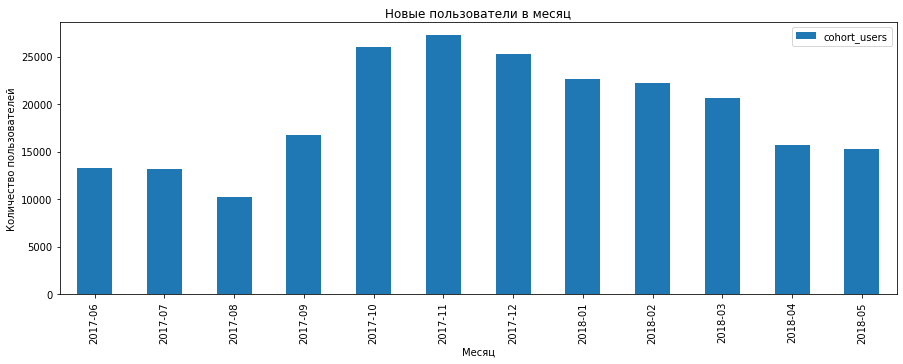

In [37]:
cohorts_visits['first_month'] = cohorts_visits['first_month'].dt.strftime('%Y-%m')
cohorts_visits = cohorts_visits.set_index('first_month')
new_users_by_month = cohorts_visits[cohorts_visits['lifetime'] == 0][['cohort_users']]
new_users_by_month.plot(kind = 'bar', figsize = (15,5), title = 'Новые пользователи в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.show()

### Метрики электронной коммерции

#### Средняя длительность времени с первого посещения сайта до совершения покупки

In [38]:
visits.head(2)

,device,end_ts,source_id,start_ts,uid,date,day,week,month,year,second
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,51,12,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,8,2,2018,1680


Из таблицы visits найдём время и дату первой сессии и рекламный исочник 

In [39]:
first_date_and_source = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
first_date_and_source.columns = ['first_activity', 'first_source']
first_date_and_source.head(2)

,first_activity,first_source
uid,,
11863502262781,2018-03-01 17:27:00,3
49537067089222,2018-02-06 15:55:00,2


Из таблицы orders найдём время первой покупки

In [40]:
orders.head(2)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [41]:
first_date_of_orders = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_date_of_orders.columns = ['first_date_orders']
first_date_of_orders.head(2)

,first_date_orders
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00


Объединим данные первых сессий и первых заказов

In [42]:
first_session_and_order_date = first_date_and_source.merge(first_date_of_orders,on='uid', how='right')
#first_session_and_order_date_1 = first_date_of_orders.join(first_date_and_source,on='uid')
first_session_and_order_date.head(2)#.info()

,first_activity,first_source,first_date_orders
uid,,,
313578113262317,2017-09-18 22:49:00,2,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00,10,2017-06-03 10:13:00


In [43]:
first_session_and_order_date['first_date_orders'] = pd.to_datetime(first_session_and_order_date['first_date_orders'])
first_session_and_order_date['first_activity'] = pd.to_datetime(first_session_and_order_date['first_activity']) 
first_session_and_order_date['time_session_to_order'] = (first_session_and_order_date['first_date_orders'] 
                                                              - first_session_and_order_date['first_activity']) / np.timedelta64(1, 'm')
print('Среднее время с певрой сессии до первой покупки: {} дней'
      .format(int(first_session_and_order_date['time_session_to_order'].mean()/60/24)))
print('Медиана времени с первой сессии до первой покупки: {} минут'
      .format(int(first_session_and_order_date['time_session_to_order'].median())))

Среднее время с певрой сессии до первой покупки: 16 дней
Медиана времени с первой сессии до первой покупки: 16 минут


Построим график распределения времни прошедшего с первой сесси до первой покупки

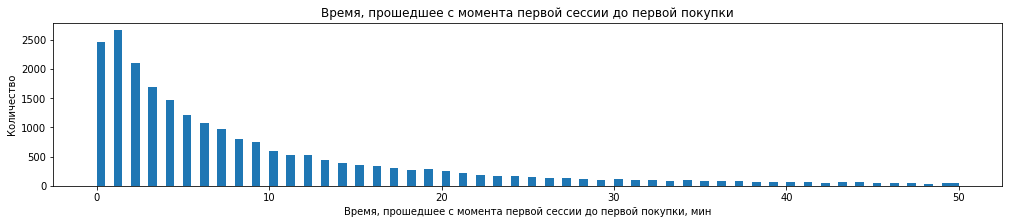

In [44]:
first_session_and_order_date['time_session_to_order'].plot(kind = 'hist', 
                                                           bins = 100, 
                                                           range = (0,50), 
                                                           figsize = (17,3), 
                                                           title = 'Время, прошедшее с момента первой сессии до первой покупки')
plt.xlabel('Время, прошедшее с момента первой сессии до первой покупки, мин')
plt.ylabel('Количество')
plt.show();

In [45]:

print('Мода времени с певрой сессии до первой покупки: {} минута'
      .format(int(first_session_and_order_date['time_session_to_order'].mode())))

Мода времени с певрой сессии до первой покупки: 1 минута


**Вывод.** У большей части пользователей на оформление заказа уходит около 1 минуты. Т.е. они заходят ресурс и сразу делают заказ. Видно, что заходят они сразу по делу, а не посидеть поискать что-либо интересное.

#### Среднее количество покупок на одного покупателя

In [46]:
orders.head(2)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [47]:
first_session_and_order_date.head(2)

,first_activity,first_source,first_date_orders,time_session_to_order
uid,,,,
313578113262317,2017-09-18 22:49:00,2,2018-01-03 21:51:00,154022.0
1575281904278712,2017-06-03 10:13:00,10,2017-06-03 10:13:00,0.0


Добавим в orders дату первого заказа и выведем в отдельный столбец месяц первого заказа

In [48]:
orders = orders.join(first_session_and_order_date, on='uid')
orders['first_month_orders_'] = orders['first_date_orders'].astype('datetime64[M]')
orders['first_month_session'] = orders['first_activity'].astype('datetime64[M]')
orders['month_buy_ts'] = orders['buy_ts'].astype('datetime64[M]')
orders.head(2)

,buy_ts,revenue,uid,first_activity,first_source,first_date_orders,time_session_to_order,first_month_orders_,first_month_session,month_buy_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:10:00,1.0,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,2017-06-01 00:25:00,11.0,2017-06-01,2017-06-01,2017-06-01


In [49]:
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_week'] = orders['buy_ts'].dt.week
orders['buy_month'] = orders['buy_ts'].dt.month
orders['buy_year'] = orders['buy_ts'].dt.year
orders.head(2)

,buy_ts,revenue,uid,first_activity,first_source,first_date_orders,time_session_to_order,first_month_orders_,first_month_session,month_buy_ts,buy_date,buy_week,buy_month,buy_year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:10:00,1.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,2017-06-01 00:25:00,11.0,2017-06-01,2017-06-01,2017-06-01,2017-06-01,22,6,2017


Найдем среднее количество покупок в день, в неделю, в месяц, в год на одного покупателя

In [50]:
orders_user_day = orders.groupby(['buy_date', 'uid']).agg({'buy_ts':'count'}).mean()[0]
print('Среднее количество покупок в день:', orders_user_day.round(2))
orders_user_week = orders.groupby(['buy_year', 'buy_week', 'uid']).agg({'buy_ts':'count'}).mean()[0]
print('Среднее количество покупок в неделю:', orders_user_week.round(2))
orders_user_month = orders.groupby(['buy_year', 'buy_month', 'uid']).agg({'buy_ts':'count'}).mean()[0]
print('Среднее количество покупок в месяц:', orders_user_month.round(2))
orders_user_year = orders.groupby(['buy_year', 'uid']).agg({'buy_ts':'count'}).mean()[0]
print('Среднее количество покупок в год:', orders_user_year.round(2))

Среднее количество покупок в день: 1.08
Среднее количество покупок в неделю: 1.16
Среднее количество покупок в месяц: 1.23
Среднее количество покупок в год: 1.32


Покупок мало, сделаем когортный анализ по количеству покупок на человека - когорты выведем по дате первой сессии

In [51]:
orders = orders[(['buy_ts', 'revenue', 'uid', 
                  'month_buy_ts', 'first_date_orders', 'first_month_orders_', 'first_month_session'])]
orders.head(2)

,buy_ts,revenue,uid,month_buy_ts,first_date_orders,first_month_orders_,first_month_session
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01


Посчитаем lifetime заказов

In [52]:
orders['lifetime'] = (((orders['month_buy_ts'] - orders['first_month_session']) 
                       / np.timedelta64(1, 'M'))).round().astype('int')

Cгруппируем заказы по когортам и lifetime и высчитаем кол-во покупок и пользователей

In [53]:
cohorts_orders = orders.groupby(['first_month_session', 'lifetime']).agg({'uid':['count', 'nunique']}).reset_index()
cohorts_orders.columns = ['first_month_session', 'lifetime', 'count_orders', 'count_users']
cohorts_orders['first_month_session'] = cohorts_orders['first_month_session'].dt.strftime('%Y-%m')

Получим количество заказов на одного пользователя по каждой когорте и кадлому lifetime

In [54]:
cohorts_orders['orders_per_user'] = cohorts_orders['count_orders'] / cohorts_orders['count_users']

Создадим сводную таблицу с когортным анализом количества заказов на пользователя

In [55]:
cohorts_orders_pivot = cohorts_orders.pivot_table(
    index = 'first_month_session', 
    columns = 'lifetime', 
    values = 'orders_per_user', 
    aggfunc = 'mean')
#cohorts_orders_pivot['mean'] = cohorts_orders_pivot.mean(axis=1)
#cohorts_orders_pivot = cohorts_orders_pivot.fillna(0)
cohorts_orders_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month_session,,,,,,,,,,,,
2017-06,1.163618,1.675325,2.116279,2.351064,2.007782,2.108374,2.645503,2.122581,2.156977,2.038462,1.622807,1.760479
2017-07,1.127210,1.362963,1.369128,1.272727,1.254902,1.278195,1.163934,1.218750,1.313043,1.208333,1.160000,NaN
2017-08,1.117550,1.416667,1.485507,1.529915,1.572816,1.407895,1.342105,1.686047,1.566038,1.448276,NaN,NaN
2017-09,1.116526,1.347945,1.365145,1.544944,1.216216,1.371429,1.385714,1.405797,1.204301,NaN,NaN,NaN
2017-10,1.135336,1.300420,1.219178,1.192893,1.237374,1.237288,1.129310,1.284553,NaN,NaN,NaN,NaN
2017-11,1.165326,1.377698,1.403042,1.732240,1.512438,1.284404,1.356589,NaN,NaN,NaN,NaN,NaN
2017-12,1.142653,1.406061,1.386243,1.336898,1.298851,1.274194,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.111952,1.412500,1.457143,1.189873,1.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.116410,1.469751,1.313131,1.311321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


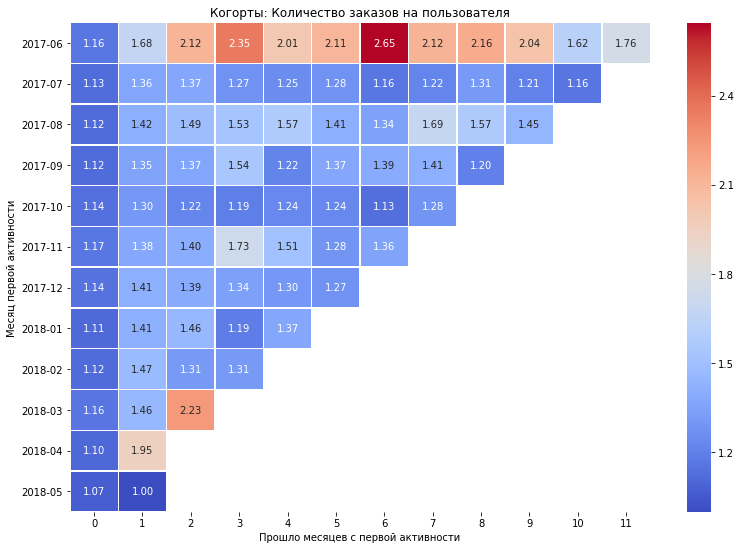

In [56]:
plt.figure(figsize=(13, 9))
plt.title('Когорты: Количество заказов на пользователя')
sns.heatmap(cohorts_orders_pivot, annot=True, fmt=".2f", linewidths=.5, cmap = 'coolwarm')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show(); 

*Среднее количество заказов на пользователя — это накопительная метрика в разбивке по когортам, пользователей в когортах больше не становится, значить и со времененем эта метрика не может падать.*

In [57]:
cohorts_orders_pivot_1 = cohorts_orders_pivot.cumsum(axis=1)
#cohorts_orders_pivot_1['mean'] = cohorts_orders_pivot_1.mean(axis=1)
#cohorts_orders_pivot_1 = cohorts_orders_pivot_1.fillna(0)
cohorts_orders_pivot_1

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month_session,,,,,,,,,,,,
2017-06,1.163618,2.838943,4.955222,7.306286,9.314068,11.422442,14.067945,16.190526,18.347502,20.385964,22.008771,23.76925
2017-07,1.127210,2.490173,3.859301,5.132028,6.386930,7.665126,8.829060,10.047810,11.360854,12.569187,13.729187,NaN
2017-08,1.117550,2.534216,4.019724,5.549638,7.122454,8.530348,9.872454,11.558500,13.124538,14.572814,NaN,NaN
2017-09,1.116526,2.464472,3.829617,5.374561,6.590777,7.962205,9.347920,10.753717,11.958018,NaN,NaN,NaN
2017-10,1.135336,2.435757,3.654935,4.847828,6.085202,7.322490,8.451800,9.736353,NaN,NaN,NaN,NaN
2017-11,1.165326,2.543024,3.946066,5.678306,7.190744,8.475148,9.831737,NaN,NaN,NaN,NaN,NaN
2017-12,1.142653,2.548713,3.934957,5.271855,6.570705,7.844899,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.111952,2.524452,3.981594,5.171468,6.538135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.116410,2.586160,3.899292,5.210612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


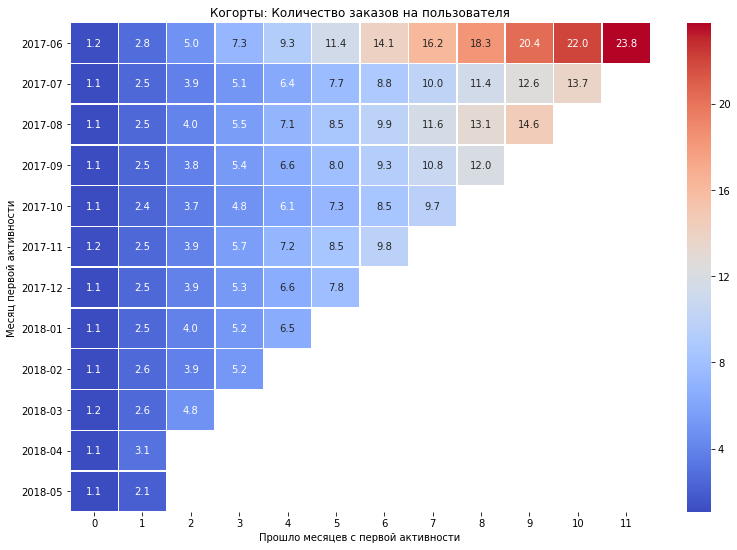

In [58]:
plt.figure(figsize=(13, 9))
plt.title('Когорты: Количество заказов на пользователя')
sns.heatmap(cohorts_orders_pivot_1, annot=True, fmt=".1f", linewidths=.5, cmap = 'coolwarm')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show(); 


<div class="alert alert-block alert-info">
Не знаю верно ли, но теперь Количество заказов на пользователя накапительно считается
</div>

<div class="alert alert-block alert-warning">
    

### Комментарий от ревьюера №1

Но смотри, у тебя получаются слишком большие значения теперь. Ты же сама ниже пишешь — Среднее количество покупок: 1.38. А у тебя на второй месяц по всех когортах уже больше.
    
Это задание можно сделать по-другому. Тебе нужно взять когорты, которые прожили 6 месяцев. Ограничить их по сроку жизнь за 6 месяцев (чтобы старые когорты не искажали данные, так как у них история есть за больший промежуток времени), а потом найти сколько в них было заказов и разделить на общее количество покупателей.

</div>

In [59]:
orders

,buy_ts,revenue,uid,month_buy_ts,first_date_orders,first_month_orders_,first_month_session,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31 23:56:00,2018-05-01,2017-10-01,7


In [60]:
cohort_size_orders = orders.groupby('first_month_orders_').agg({'uid':['nunique','count']}).reset_index()
cohort_size_orders.columns = ['activity_month','buyers','orders']
cohort_size_orders['orders_per_user'] = cohort_size_orders['orders']/cohort_size_orders['buyers']
cohort_size_orders

,activity_month,buyers,orders,orders_per_user
0,2017-06-01,2023,4438,2.193772
1,2017-07-01,1923,2910,1.513261
2,2017-08-01,1370,2188,1.597080
3,2017-09-01,2581,3878,1.502518
4,2017-10-01,4340,6005,1.383641
5,2017-11-01,4081,5900,1.445724
6,2017-12-01,4383,5894,1.344741
7,2018-01-01,3373,4308,1.277201
8,2018-02-01,3651,4470,1.224322
9,2018-03-01,3533,4484,1.269176


In [61]:
cohort_size_orders = cohort_size_orders.query('activity_month <= "2017-11-01"')
cohort_size_orders

,activity_month,buyers,orders,orders_per_user
0,2017-06-01,2023,4438,2.193772
1,2017-07-01,1923,2910,1.513261
2,2017-08-01,1370,2188,1.597080
3,2017-09-01,2581,3878,1.502518
4,2017-10-01,4340,6005,1.383641
5,2017-11-01,4081,5900,1.445724


In [62]:
cohort_size_orders['orders_per_user'].mean()

1.605999248773

<div class="alert alert-block alert-info">
**4.18  Комментарий от ревьюера №1**

Так?
</div>

<div class="alert alert-block alert-warning">
    

### Комментарий от ревьюера №4

Тут первоначальный датасет нужно было еще ограничить по самой дате покупки. А то у тебя получилось, что в когорте 2017-06-01 данные за 12 месяцев, а в 2017-11-01 за 6.

</div>

Расчитаем  среднее количество покупок в день на пользователя 

In [64]:
display(cohorts_orders.head(2))
print('Среднее количество покупок в день:',cohorts_orders['count_orders'].sum()/cohorts_orders['count_users'].sum() )

,first_month_session,lifetime,count_orders,count_users,orders_per_user
0,2017-06,0,2354,2023,1.163618
1,2017-06,1,387,231,1.675325


Среднее количество покупок в день: 1.2290645798288597


In [65]:
#orders

In [66]:
users_orders = orders.groupby('uid')['revenue'].count().reset_index()
users_orders.columns = ['user','order']
print('Среднее количество покупок:',users_orders['order'].sum()/users_orders['user'].count())

Среднее количество покупок: 1.3803630588943954


Выделяется первая когорта по среднему показателю за все периоды и по самому высокому показателю по всем когортам, после идет мартовская когорта за 2018 год и следом апрельская 2018 года. Так же можно наблюдать, что первый месяц все пользователи присматриваются к сервису.

</div>

#### Средний чек

Cгруппируем заказы по когортам и lifetime и суммам покупок на одного пользователя

In [67]:
#orders.head(2)

In [68]:
orders_cohorts_check = orders.groupby(['first_month_session', 'lifetime']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_cohorts_check.columns = ['first_month', 'lifetime', 'revenue_total', 'count_users']
orders_cohorts_check['revenue_one_user'] = orders_cohorts_check['revenue_total'] / orders_cohorts_check['count_users']
orders_cohorts_check['first_month'] = orders_cohorts_check['first_month'].dt.strftime('%Y-%m')
orders_cohorts_check.head(10)

,first_month,lifetime,revenue_total,count_users,revenue_one_user
0,2017-06,0,9557.49,2023,4.724414
1,2017-06,1,2664.58,231,11.534978
2,2017-06,2,1464.69,129,11.354186
3,2017-06,3,3882.09,188,20.649415
4,2017-06,4,3940.59,257,15.333035
5,2017-06,5,2824.48,203,13.913695
6,2017-06,6,3489.95,189,18.465344
7,2017-06,7,2270.81,155,14.650387
8,2017-06,8,2317.91,172,13.476221
9,2017-06,9,3481.64,156,22.318205


Cоздадим сводную таблицу с когортным анализом суммы покупок на пользователя и построим тепловую карту

In [69]:
orders_cohorts_check_pivot = orders_cohorts_check.pivot_table(
    index = 'first_month', 
    columns = 'lifetime', 
    values = 'revenue_one_user', 
    aggfunc = 'mean')
orders_cohorts_check_pivot['mean'] = orders_cohorts_check_pivot.mean(axis=1)
orders_cohorts_check_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,mean
first_month,,,,,,,,,,,,,
2017-06,4.724414,11.534978,11.354186,20.649415,15.333035,13.913695,18.465344,14.650387,13.476221,22.318205,19.333421,11.543772,14.774756
2017-07,5.633137,7.846519,7.442282,6.382857,5.535882,6.000602,4.819672,6.017969,6.300174,8.208750,6.228800,NaN,6.401513
2017-08,5.161267,6.393077,7.256159,8.087265,7.864466,7.011842,6.403289,14.491047,15.672453,6.477931,NaN,NaN,8.481880
2017-09,5.475055,10.138301,8.757801,58.645674,11.607928,13.643214,6.906000,7.121449,4.500753,NaN,NaN,NaN,14.088464
2017-10,4.882297,8.003845,4.544589,5.370812,5.270051,5.775085,4.990603,5.332520,NaN,NaN,NaN,NaN,5.521225
2017-11,4.924573,4.797806,5.105894,7.483770,5.516119,6.492018,5.415504,NaN,NaN,NaN,NaN,NaN,5.676526
2017-12,4.828702,5.269788,22.213228,27.400107,16.753678,14.372016,NaN,NaN,NaN,NaN,NaN,NaN,15.139587
2018-01,4.007946,6.099063,6.655771,3.871899,5.860778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.299091
2018-02,4.036687,7.062135,6.698889,8.500094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.574451


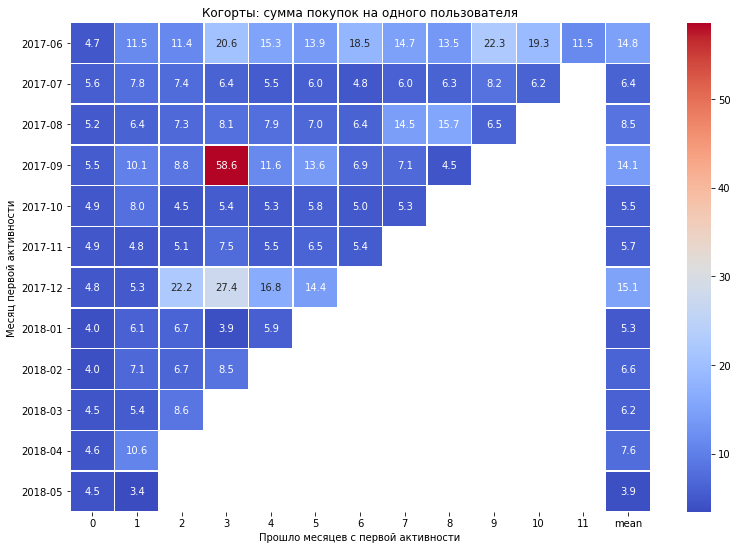

In [70]:
plt.figure(figsize=(13, 9))
plt.title('Когорты: сумма покупок на одного пользователя')
sns.heatmap(orders_cohorts_check_pivot, annot=True, fmt=".1f", linewidths=.5, cmap = 'coolwarm')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первой активности')
plt.show()

Имеются две аномальные когорты на 4-й месяц существования, у них максимальные показатели среднего чека(58,6 и 27,4). В целом все когорты имеют возрастание среднего чека на 2-й месяц, так же показатели показывают положительный тренд и со временем цифра не опускается ниже начальной.

Средний чек исходя из когортного анализа равен 8,3

In [71]:
orders_cohorts_check_pivot['mean'].mean().round(2)

8.3

Средний чек применяя группировку по времени совершения покупки

In [72]:
orders_month_check = orders.groupby(['month_buy_ts']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_month_check.columns = ['month', 'revenue_total', 'count_users']
orders_month_check['revenue_one_user'] = orders_month_check['revenue_total'] / orders_month_check['count_users']
orders_month_check['month'] = orders_month_check['month'].dt.strftime('%Y-%m')
orders_month_check

,month,revenue_total,count_users,revenue_one_user
0,2017-06,9557.49,2023,4.724414
1,2017-07,12539.47,1984,6.320297
2,2017-08,8758.78,1472,5.950258
3,2017-09,18345.51,2750,6.671095
4,2017-10,27987.70,4675,5.986674
5,2017-11,27069.93,4547,5.953360
6,2017-12,36388.60,4942,7.363132
7,2018-01,19417.13,3898,4.981306
8,2018-02,25560.54,4258,6.002945
9,2018-03,28834.59,4181,6.896577


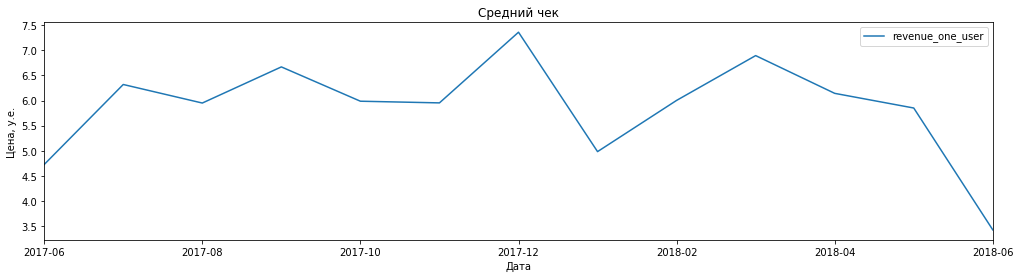

In [73]:
orders_month_check_new = orders_month_check[(['month', 'revenue_one_user'])]

orders_month_check_new.plot(x ='month',  figsize = (17,4),title = 'Средний чек')
plt.xlabel('Дата')
plt.ylabel('Цена, у.е.')
plt.show()

In [74]:
orders_month_check['revenue_one_user'].mean().round(2)

5.87

**Вывод.** Средний чек исходя из когортного анализа равен примерно 8 у.е. Можно отметить несколько аномальных когорт - 4 (сентябрьская) и 7 (декабрьская). Средний чек групируя по времени равен 6 у.е.

Найдем средний чек заказа

In [77]:
cohorts_orders = orders.groupby(['month_buy_ts', 'lifetime']).agg({'uid':['count', 'nunique']}).reset_index()
cohorts_orders.columns = ['first_month_session', 'lifetime', 'count_orders', 'count_users']
cohorts_orders['first_month_session'] = cohorts_orders['first_month_session'].dt.strftime('%Y-%m')

In [78]:
orders

,buy_ts,revenue,uid,month_buy_ts,first_date_orders,first_month_orders_,first_month_session,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31 23:56:00,2018-05-01,2017-10-01,7


In [79]:
cohorts_orders_month = orders.groupby('month_buy_ts').agg({'uid':['count', 'nunique'], 'revenue':'sum'}).reset_index()
cohorts_orders_month.columns = ['month', 'count_orders', 'count_users','revenue' ]
cohorts_orders_month['revenue_per_order'] = cohorts_orders_month['revenue']/ cohorts_orders_month['count_orders']
cohorts_orders_month

,month,count_orders,count_users,revenue,revenue_per_order
0,2017-06-01,2354,2023,9557.49,4.060106
1,2017-07-01,2363,1984,12539.47,5.306589
2,2017-08-01,1807,1472,8758.78,4.847139
3,2017-09-01,3387,2750,18345.51,5.416448
4,2017-10-01,5679,4675,27987.70,4.928280
5,2017-11-01,5659,4547,27069.93,4.783518
6,2017-12-01,6218,4942,36388.60,5.852139
7,2018-01-01,4721,3898,19417.13,4.112927
8,2018-02-01,5281,4258,25560.54,4.840095
9,2018-03-01,5326,4181,28834.59,5.413930


In [80]:
print('Cредний чек заказа:', (cohorts_orders_month['revenue'].sum() / cohorts_orders_month['count_orders'].sum()).round(2))

Cредний чек заказа: 5.0


#### LTV - сумма которую приносит один клиент

In [88]:
visits_new = visits
visits_new.head(3)

,device,end_ts,source_id,start_ts,uid,date,day,week,month,year,second
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,51,12,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,8,2,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,26,7,2017,0


Узнаем источник 1 визита пользователя и считаем, что он всегда покупает из него

In [89]:
uids_sources = visits_new.sort_values(by='start_ts').groupby('uid', as_index=False).agg({'source_id': 'first'})
uids_sources

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


Добавим источник покупки по uid пользователя

In [90]:
orders_with_source = orders.merge(uids_sources, on='uid') #, how='left'
orders_with_source

,buy_ts,revenue,uid,month_buy_ts,first_date_orders,first_month_orders_,first_month_session,lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31 23:56:00,2018-05-01,2017-10-01,7,3


In [91]:
cohort__sizes = orders_with_source.groupby(['source_id', 'first_month_orders_']) .agg({'uid': 'nunique'}).reset_index()
cohort__sizes.columns = ['source_id', 'first_activity_month', 'n_buyers']
cohort__sizes

,source_id,first_activity_month,n_buyers
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
...,...,...,...
81,10,2018-01-01,92
82,10,2018-02-01,123
83,10,2018-03-01,186
84,10,2018-04-01,107


In [92]:
cohort = (orders_with_source.groupby(['source_id', 'first_month_orders_', 'month_buy_ts'])
    .agg({'revenue': 'sum'})).reset_index()
cohort.columns = ['source_id', 'first_activity_month', 'activity_month', 'revenue']
cohort

,source_id,first_activity_month,activity_month,revenue
0,1,2017-06-01,2017-06-01,1378.70
1,1,2017-06-01,2017-07-01,414.98
2,1,2017-06-01,2017-08-01,419.43
3,1,2017-06-01,2017-09-01,714.24
4,1,2017-06-01,2017-10-01,811.20
...,...,...,...,...
511,10,2018-03-01,2018-03-01,638.44
512,10,2018-03-01,2018-04-01,12.71
513,10,2018-03-01,2018-05-01,6.29
514,10,2018-04-01,2018-04-01,261.93


In [93]:
report_table = pd.merge(cohort, cohort__sizes, on=['source_id', 'first_activity_month'])
report_table

,source_id,first_activity_month,activity_month,revenue,n_buyers
0,1,2017-06-01,2017-06-01,1378.70,190
1,1,2017-06-01,2017-07-01,414.98,190
2,1,2017-06-01,2017-08-01,419.43,190
3,1,2017-06-01,2017-09-01,714.24,190
4,1,2017-06-01,2017-10-01,811.20,190
...,...,...,...,...,...
511,10,2018-03-01,2018-03-01,638.44,186
512,10,2018-03-01,2018-04-01,12.71,186
513,10,2018-03-01,2018-05-01,6.29,186
514,10,2018-04-01,2018-04-01,261.93,107


Вычислим выручку, время жизни, LTV

In [94]:
margin_rate = 1
report_table['gp'] = report_table['revenue'] * margin_rate
report_table['age'] = (report_table['activity_month'] - report_table['first_activity_month']) / np.timedelta64(1, 'M')
report_table['age'] = report_table['age'].round().astype('int')
report_table['ltv'] = report_table['gp'] / report_table['n_buyers']
report_table['first_activity_month'] = report_table['first_activity_month'].dt.strftime('%Y-%m')
report_table

,source_id,first_activity_month,activity_month,revenue,n_buyers,gp,age,ltv
0,1,2017-06,2017-06-01,1378.70,190,1378.70,0,7.256316
1,1,2017-06,2017-07-01,414.98,190,414.98,1,2.184105
2,1,2017-06,2017-08-01,419.43,190,419.43,2,2.207526
3,1,2017-06,2017-09-01,714.24,190,714.24,3,3.759158
4,1,2017-06,2017-10-01,811.20,190,811.20,4,4.269474
...,...,...,...,...,...,...,...,...
511,10,2018-03,2018-03-01,638.44,186,638.44,0,3.432473
512,10,2018-03,2018-04-01,12.71,186,12.71,1,0.068333
513,10,2018-03,2018-05-01,6.29,186,6.29,2,0.033817
514,10,2018-04,2018-04-01,261.93,107,261.93,0,2.447944


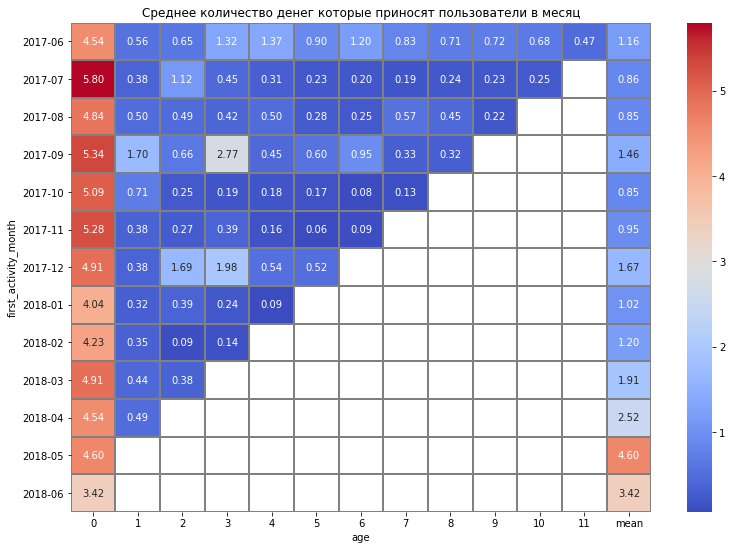

In [95]:
LTV_pivot_new = report_table.pivot_table(index='first_activity_month',
                columns= 'age',
                values='ltv',
                aggfunc= 'mean')
LTV_pivot_new['mean'] = LTV_pivot_new.mean(axis=1)
plt.figure(figsize=(13, 9))
plt.title('Среднее количество денег которые приносят пользователи в месяц')
sns.heatmap(LTV_pivot_new, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap = 'coolwarm')

LTV - накопительная метрика, отобразим итоговые LTV каждй когорты

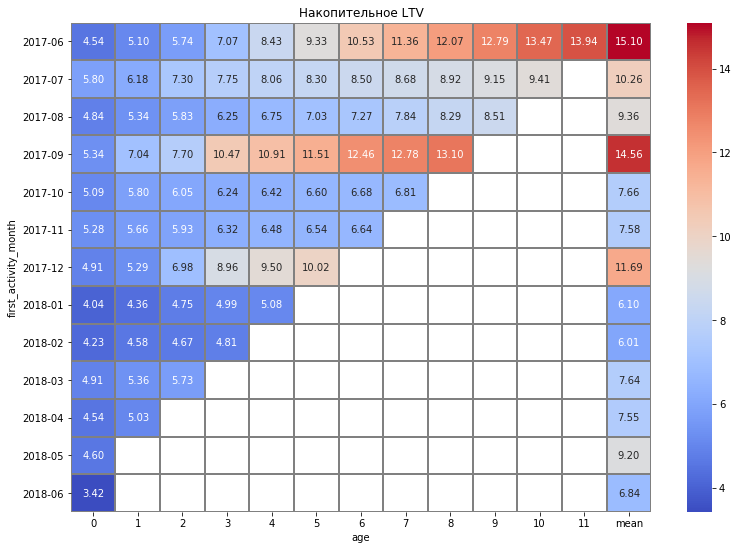

In [96]:
LTV_pivot_new = LTV_pivot_new.cumsum(axis=1)
plt.figure(figsize=(13, 9))
plt.title('Накопительное LTV')
sns.heatmap(LTV_pivot_new, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap = 'coolwarm')


Pассчитаем LTV по источникам

In [97]:
for source in report_table['source_id'].unique():
    t = report_table.query("source_id==@source")
    t = t.pivot_table(index='first_activity_month', columns='age', values='ltv').cumsum(axis=1)
    t = t.fillna('').style.set_caption(f'Source: {source}')
    display(t)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,7.25632,9.44042,11.6479,15.4071,19.6766,21.7257,24.3072,26.8295,29.1039,30.7687,31.9735,33.6442
2017-07,7.29187,8.38756,13.7422,15.2492,16.1275,17.0274,17.4742,18.1204,18.9774,19.9628,20.8908,
2017-08,7.49336,8.69062,9.70088,10.6657,11.705,12.3713,13.0515,15.7087,17.9019,18.6806,,
2017-09,6.01471,7.81652,8.37581,9.30066,9.33943,9.43476,9.51974,9.82661,10.4165,,,
2017-10,6.01862,7.07444,7.31921,7.70703,7.77029,7.8785,8.06182,8.38259,,,,
2017-11,7.3909,7.96469,8.92827,9.82219,9.98546,10.0914,10.1721,,,,,
2017-12,4.58429,4.89532,5.18408,5.42979,5.45637,5.55199,,,,,,
2018-01,5.76882,5.85933,6.00387,6.97723,7.02651,,,,,,,
2018-02,4.68655,5.6864,5.75375,6.12327,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,4.44119,4.93285,5.20477,7.12966,8.79647,9.71545,11.3177,12.7998,14.1351,14.8688,16.2274,16.6607
2017-07,8.42966,9.19524,9.25457,9.57635,10.0085,10.1948,10.4936,10.6306,10.7417,10.9708,11.3345,
2017-08,5.73886,6.6748,6.85309,7.10398,7.61911,7.6822,7.8039,8.19699,8.23016,8.31455,,
2017-09,8.28222,16.4107,18.7731,19.6962,21.1044,22.0794,25.3972,26.1505,26.7028,,,
2017-10,7.67636,10.1322,10.793,11.333,11.8893,12.1557,12.2553,12.5076,,,,
2017-11,6.98935,7.89789,8.3355,9.11907,9.43224,9.57543,9.71985,,,,,
2017-12,8.80898,10.3514,19.6825,30.7828,33.828,37.038,,,,,,
2018-01,4.34332,5.43339,7.17062,7.41534,7.74435,,,,,,,
2018-02,5.41703,6.06444,6.38761,6.64324,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,4.39552,4.50832,4.69473,5.00594,5.19165,5.38487,5.51279,5.5424,5.59245,5.64549,5.67365,5.70583
2017-07,6.10512,6.36789,6.49168,6.88566,6.92564,6.99662,7.03313,7.16533,7.24943,7.29023,7.34578,
2017-08,5.07864,5.23341,5.52136,5.62834,5.79039,5.83967,5.90412,5.99685,6.07555,6.13647,,
2017-09,5.5631,5.81086,6.13534,6.22292,6.44677,6.56588,6.69325,6.76727,6.88771,,,
2017-10,4.78681,5.24372,5.36279,5.42515,5.5335,5.62855,5.6467,5.72018,,,,
2017-11,4.53244,4.66725,4.75146,4.8695,4.92499,4.95665,4.98995,,,,,
2017-12,4.17885,4.31071,4.45282,4.57896,4.67752,4.73879,,,,,,
2018-01,4.11441,4.29639,4.42862,4.50799,4.5613,,,,,,,
2018-02,3.78775,4.0974,4.1856,4.24697,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,4.74538,4.78571,4.95659,5.416,6.56443,8.05332,9.48264,9.71574,9.9323,10.7349,12.0039,12.0888
2017-07,5.54474,5.60383,5.68429,5.84449,5.90044,5.96271,6.0648,6.11006,6.19691,6.25785,6.27973,
2017-08,5.06497,5.23364,5.36456,5.63172,5.77802,5.9868,6.06997,6.2595,6.35225,6.47547,,
2017-09,4.76668,5.24734,5.56081,5.8489,5.89864,6.13581,7.39053,7.65612,7.70771,,,
2017-10,4.36794,4.5139,4.66532,4.77701,4.89622,4.9885,5.07634,5.14078,,,,
2017-11,5.14379,5.79124,5.89176,6.2973,6.49174,6.53549,6.75611,,,,,
2017-12,4.17198,4.26129,4.35322,4.43889,4.47869,4.56402,,,,,,
2018-01,3.78165,3.90216,3.98516,4.05843,4.08823,,,,,,,
2018-02,4.09338,4.20353,4.23873,4.25723,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,4.94503,5.84797,6.29727,7.17,7.83331,8.13104,9.03638,9.62346,10.1818,11.1274,11.2835,11.4001
2017-07,5.28655,5.60608,6.06083,6.21411,6.31109,6.41896,6.44539,6.55579,6.6482,6.70504,6.77983,
2017-08,5.05014,5.80236,6.63414,7.34447,8.42417,9.01881,9.40392,9.65014,9.88792,10.1225,,
2017-09,6.19647,6.37893,6.71039,22.8783,23.6511,25.6695,25.9497,26.1503,26.1728,,,
2017-10,5.09107,5.31412,5.43449,5.55658,5.66995,5.76746,5.91145,6.03714,,,,
2017-11,4.56039,4.74763,4.8654,4.92087,5.05792,5.09788,5.20633,,,,,
2017-12,5.00695,5.14228,5.23223,5.287,5.30647,5.31449,,,,,,
2018-01,4.35175,4.87009,5.25466,5.2863,5.3139,,,,,,,
2018-02,4.32173,4.41403,4.46025,4.47012,,,,,,,,


age,0
first_activity_month,
2017-08,1.22


age,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2017-06,3.56897,3.64074,4.22868,4.83588,5.10338,5.54603,6.07794,6.20191,6.73956,6.8625,6.94338
2017-07,4.46904,4.62712,5.25462,5.74019,6.10808,6.16962,6.45519,6.51385,6.94442,6.96788,7.04192
2017-08,4.07492,4.27328,4.91393,5.14508,5.19918,5.26705,5.40328,5.69377,5.77492,5.92525,
2017-09,4.29713,5.31977,5.94943,6.75241,7.3508,7.4792,8.0946,8.76023,9.6692,,
2017-10,5.06373,5.60405,6.04246,6.15881,6.4469,6.98865,7.00619,7.02508,,,
2017-11,3.73945,3.87262,4.03724,4.32393,4.47414,4.50531,4.52634,,,,
2017-12,3.82587,4.13992,4.31256,4.57893,4.60314,4.7495,,,,,
2018-01,2.83425,3.05213,3.25388,3.29113,3.314,,,,,,
2018-02,4.80083,4.97381,5.04976,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9
first_activity_month,,,,,,,,,,
2017-06,2.41421,2.53063,,,,,,,2.53958,
2017-07,3.46137,3.49255,,3.64216,,,,,3.64941,
2017-08,4.9973,5.10946,5.43973,,,,,5.56351,,5.65432
2017-09,2.23407,2.29872,2.38105,2.57209,2.60047,,,2.61035,2.63523,
2017-10,2.61871,2.70206,2.7123,2.72923,2.76751,2.77727,2.79718,2.84919,,
2017-11,4.6218,4.67422,4.68852,4.8743,4.97898,5.02867,5.08352,,,
2017-12,3.79094,3.92753,,,,3.98506,,,,
2018-01,3.09902,3.11424,3.18402,,,,,,,
2018-02,2.47374,2.58967,2.59366,,,,,,,


Для расчета САС расчитаем общие затраты по каждому источнику и кол-во уник покупателей из каждого источника


In [98]:
costs.groupby('source_id', as_index=False).agg({'costs': 'sum'})

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [99]:
orders_with_source.groupby('source_id', as_index=False).agg({'uid': 'nunique'})

,source_id,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [100]:
cac_by_source =(     orders_with_source.groupby('source_id', as_index=False).agg({'uid': 'nunique'})
    .merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}), on='source_id')
    .assign(cac=lambda row: row['costs'] / row['uid'])      )
cac_by_source

,source_id,uid,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


### Расчитаем ROMI для каждого ресурса

In [101]:
for source in [ 1,  2,  3,  4,  5,  9, 10]:
    ltv_ = report_table.query("source_id==@source")\
        .pivot_table(index='first_activity_month', columns='age', values='ltv')\
        .cumsum(axis=1)
    cac_ = cac_by_source.loc[cac_by_source['source_id'] == source, 'cac'].values[0]
    romi_ = ltv_ / cac_
    display(romi_.fillna('').style.set_caption(f'ROmi for source: {source}'))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,1.00973,1.31366,1.62084,2.14394,2.73804,3.02319,3.38241,3.73339,4.04988,4.28154,4.44919,4.68167
2017-07,1.01468,1.16715,1.91226,2.12196,2.24418,2.3694,2.43158,2.52149,2.64076,2.77787,2.907,
2017-08,1.04272,1.20932,1.3499,1.48415,1.62877,1.7215,1.81615,2.1859,2.49109,2.59945,,
2017-09,0.836962,1.08769,1.16551,1.29421,1.2996,1.31287,1.32469,1.3674,1.44948,,,
2017-10,0.837505,0.984426,1.01849,1.07245,1.08126,1.09631,1.12182,1.16646,,,,
2017-11,1.02846,1.10831,1.24239,1.36678,1.3895,1.40425,1.41548,,,,,
2017-12,0.637915,0.681195,0.721377,0.755568,0.759268,0.772573,,,,,,
2018-01,0.802746,0.81534,0.835452,0.970898,0.977756,,,,,,,
2018-02,0.652144,0.791276,0.800648,0.852068,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,0.363753,0.404022,0.426293,0.58395,0.720469,0.795737,0.926965,1.04836,1.15773,1.21782,1.32909,1.36458
2017-07,0.690426,0.75313,0.757989,0.784344,0.81974,0.834995,0.859472,0.870694,0.879794,0.898553,0.928342,
2017-08,0.470038,0.546695,0.561298,0.581847,0.624038,0.629205,0.639173,0.671369,0.674086,0.680998,,
2017-09,0.678349,1.34411,1.5376,1.61321,1.72854,1.8084,2.08014,2.14184,2.18707,,,
2017-10,0.628727,0.829875,0.883994,0.928222,0.973785,0.995601,1.00376,1.02442,,,,
2017-11,0.572458,0.646871,0.682714,0.746891,0.772541,0.784269,0.796098,,,,,
2017-12,0.721493,0.847826,1.61208,2.52124,2.77066,3.03358,,,,,,
2018-01,0.355737,0.445018,0.587305,0.607349,0.634296,,,,,,,
2018-02,0.443678,0.496704,0.523173,0.54411,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,0.325741,0.334101,0.347915,0.370978,0.38474,0.39906,0.408539,0.410734,0.414442,0.418373,0.42046,0.422845
2017-07,0.452435,0.471909,0.481082,0.51028,0.513243,0.518502,0.521208,0.531005,0.537238,0.540261,0.544378,
2017-08,0.376365,0.387835,0.409175,0.417102,0.429111,0.432764,0.43754,0.444412,0.450244,0.454759,,
2017-09,0.412268,0.430628,0.454675,0.461165,0.477755,0.486581,0.496021,0.501506,0.510431,,,
2017-10,0.354738,0.388599,0.397423,0.402044,0.410074,0.417118,0.418463,0.423909,,,,
2017-11,0.335888,0.345879,0.352119,0.360867,0.364979,0.367325,0.369793,,,,,
2017-12,0.309684,0.319456,0.329987,0.339335,0.34664,0.35118,,,,,,
2018-01,0.304909,0.318395,0.328194,0.334076,0.338027,,,,,,,
2018-02,0.280701,0.303648,0.310184,0.314732,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,0.799992,0.806792,0.835599,0.913049,1.10665,1.35766,1.59862,1.63791,1.67442,1.80973,2.02366,2.03797
2017-07,0.934751,0.944713,0.958278,0.985284,0.994718,1.00521,1.02242,1.03005,1.0447,1.05497,1.05866,
2017-08,0.85387,0.882305,0.904376,0.949414,0.974078,1.00928,1.0233,1.05525,1.07088,1.09166,,
2017-09,0.803583,0.884615,0.937461,0.986028,0.994414,1.0344,1.24592,1.2907,1.29939,,,
2017-10,0.736363,0.760969,0.786497,0.805324,0.825422,0.840978,0.855787,0.86665,,,,
2017-11,0.867158,0.976307,0.993253,1.06162,1.0944,1.10178,1.13897,,,,,
2017-12,0.703326,0.718384,0.733882,0.748323,0.755034,0.769419,,,,,,
2018-01,0.637523,0.65784,0.671833,0.684184,0.689207,,,,,,,
2018-02,0.690077,0.708645,0.714579,0.717699,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,0.662208,0.783125,0.843292,0.960163,1.04899,1.08886,1.2101,1.28872,1.36349,1.49012,1.51101,1.52663
2017-07,0.707943,0.750732,0.81163,0.832157,0.845143,0.859589,0.863128,0.877912,0.890287,0.897898,0.907915,
2017-08,0.676284,0.777017,0.888404,0.983528,1.12811,1.20774,1.25932,1.29229,1.32413,1.35554,,
2017-09,0.829794,0.854228,0.898615,3.06373,3.16721,3.43751,3.47502,3.50189,3.5049,,,
2017-10,0.681765,0.711635,0.727754,0.744104,0.759285,0.772344,0.791626,0.808458,,,,
2017-11,0.6107,0.635775,0.651545,0.658973,0.677327,0.682677,0.697201,,,,,
2017-12,0.670501,0.688624,0.700669,0.708004,0.710611,0.711684,,,,,,
2018-01,0.582761,0.652174,0.703673,0.70791,0.711606,,,,,,,
2018-02,0.57874,0.5911,0.59729,0.598611,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2017-06,0.703769,0.717921,0.833857,0.953593,1.00634,1.09363,1.19852,1.22296,1.32898,1.35322,1.36917
2017-07,0.881255,0.912426,1.03616,1.13191,1.20446,1.21659,1.27291,1.28447,1.36938,1.374,1.3886
2017-08,0.803538,0.842653,0.968984,1.01456,1.02523,1.03862,1.06548,1.12276,1.13876,1.16841,
2017-09,0.847355,1.04901,1.17317,1.33152,1.44951,1.47483,1.59618,1.72744,1.90668,,
2017-10,0.998523,1.10507,1.19152,1.21446,1.27127,1.3781,1.38156,1.38528,,,
2017-11,0.737386,0.763646,0.796108,0.852641,0.88226,0.888407,0.892555,,,,
2017-12,0.754427,0.816355,0.850399,0.902923,0.907698,0.93656,,,,,
2018-01,0.558889,0.601852,0.641635,0.648981,0.653491,,,,,,
2018-02,0.946682,0.980791,0.995768,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9
first_activity_month,,,,,,,,,,
2017-06,0.55105,0.577624,,,,,,,0.579666,
2017-07,0.790068,0.797184,,0.831333,,,,,0.832989,
2017-08,1.14065,1.16625,1.24163,,,,,1.26989,,1.29062
2017-09,0.509933,0.52469,0.543481,0.587088,0.593564,,,0.59582,0.601499,
2017-10,0.597728,0.616752,0.619089,0.622956,0.631693,0.63392,0.638464,0.650335,,
2017-11,1.05494,1.0669,1.07017,1.11257,1.13647,1.14781,1.16033,,,
2017-12,0.865293,0.89647,,,,0.909601,,,,
2018-01,0.707361,0.710834,0.726762,,,,,,,
2018-02,0.564638,0.591101,0.59201,,,,,,,


Расчитаем средний LTV по когортам за 6 месяцев

In [103]:
LTV_pivot_new.mean()[6]

8.6775741290878

Для более подробного анализа был выведен как "точечный" LTV , так и накопительный . Можно заметить, что первые когорты (2017 года) были более "качественные", чем последующие - их накопительный LTV заметно выше, чем по остальным когортам.


### Маркетинговые метрики

#### Сколько всего потратили денег

In [104]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [105]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
#costs['cost_month'] = costs['cost_month'].dt.strftime('%Y-%m')

In [106]:
costs['costs'].sum()

329131.62

Всего потрачено на маркетинг 329131.62

#### Сколько денег потратили на каждый источник

Расчитаем затраты на каждый источник рекламы

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


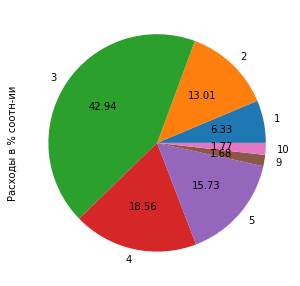

In [107]:
costs_bu_source = costs.groupby('source_id').sum()
display(costs_bu_source)

costs_bu_source.plot(y = 'costs', autopct='%.2f', kind = 'pie', figsize = (5, 5), legend = False)
plt.ylabel('Расходы в % соотн-ии')
plt.show()

Как мы видим из диаграммы самый затратный источник 3-й - в него мы делаем больше всего вложений (более 40% от суммы всех вложений в рекламу), после идут 4-й, 5-й, 2-й.

In [108]:
costs_pivot = costs.pivot_table(
    index = 'cost_month', 
    columns = 'source_id', 
    values = 'costs', 
    aggfunc = 'sum')
costs_pivot


source_id,1,2,3,4,5,9,10
cost_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


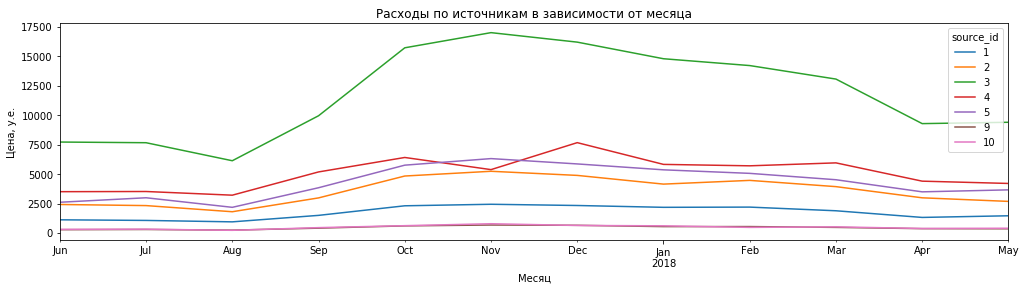

In [109]:
costs_pivot.plot(figsize = (17,4), title = 'Расходы по источникам в зависимости от месяца')
plt.xlabel('Месяц')
plt.ylabel('Цена, у.е.')
plt.show()

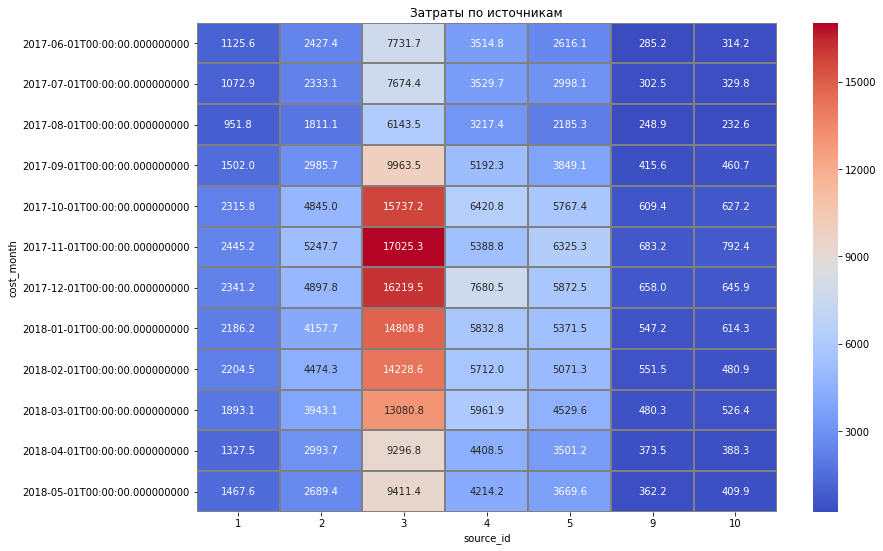

In [110]:
plt.figure(figsize=(13, 9))
plt.title('Затраты по источникам')
sns.heatmap(costs_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', cmap = 'coolwarm')

Из данной тепловой диаграммы тоже можно налюдать, как больше всего вкладываются в 3 рекламный источник

#### Сколько денег потратили за месяцы

In [111]:
costs_month = costs.pivot_table(index = 'cost_month', values = 'costs', aggfunc = 'sum')
costs_month

,costs
cost_month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


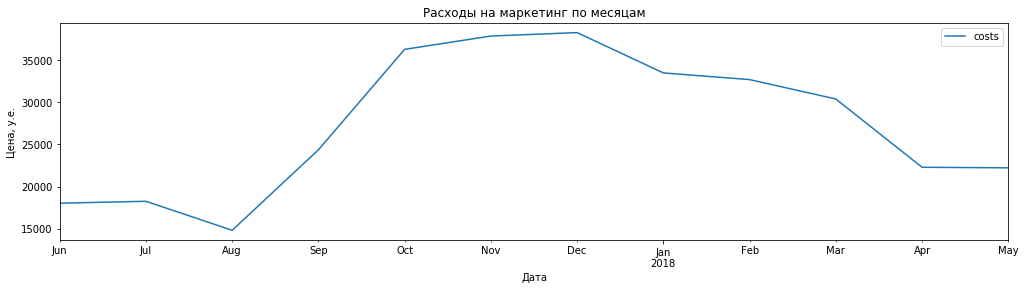

In [112]:
costs_month.plot(title = 'Расходы на маркетинг по месяцам', figsize = (17,4))
plt.xlabel('Дата')
plt.ylabel('Цена, у.е.')
plt.show()

Начиная с августа 2017 года вложения в рекламу начали увеличиваться. В ноябре того же года они достигли пика практически по всем рекланым каналам.
Самый активный период вливаний денег в рекламу октября 2017 года по март 2018 года.
В остальные периоды активность по заказу рекламы есть, но уже значительно ниже.

#### Средняя стоимость привлечения покупателя

In [113]:
visits.head()


,device,end_ts,source_id,start_ts,uid,date,day,week,month,year,second
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,51,12,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,8,2,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,26,7,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,20,5,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,52,12,2017,0


In [114]:
visits_sorted = visits.sort_values(by='start_ts')

Кол-во пользователей приходивших в сервис по разному кол-ву источников

In [115]:
uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})
uid_per_source

,uid
source_id,
1,18999
2,26245
3,74756
4,83525
5,56974
6,6
7,34
9,9264
10,8067


Ранее посчитанные затраты по каждому источнику

In [116]:
costs_bu_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [117]:
first_source_per_user = visits.groupby('uid').agg({'source_id': 'first'})#.reset_index()
####first_source_per_user.columns = ['uid', 'first_source_id']
first_source_per_user

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


Тут мы искали источник по времени первого визита, а не по времени первой покупки, от этого достаточно много зависит в дальнейшем, ведь покупатель у нас мог заходить с разных источников и с первого он мог не всегда купить. Поэтому далее считаю по времени первой покупки

In [118]:
month_source = costs.groupby(['cost_month','source_id'])['costs'].sum()
month_source

cost_month  source_id
2017-06-01  1            1125.61
            2            2427.38
            3            7731.65
            4            3514.80
            5            2616.12
                          ...   
2018-05-01  3            9411.42
            4            4214.21
            5            3669.56
            9             362.17
            10            409.86
Name: costs, Length: 84, dtype: float64

In [119]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits

,device,end_ts,source_id,start_ts,uid,date,day,week,month,year,second,session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,51,12,2017,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,8,2,2018,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,26,7,2017,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,20,5,2018,1440,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,52,12,2017,0,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,29,30,7,2017,19,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,25,4,1,2018,19,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,3,9,3,2018,19,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2,44,11,2017,19,2017-11-01


In [120]:
users = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id':'first',
                                                                       'session_month':'first'})
users = users.reset_index().rename(columns = {'session_month':'cost_month'})
users

,uid,source_id,cost_month
0,11863502262781,3,2018-03-01
1,49537067089222,2,2018-02-01
2,297729379853735,3,2017-06-01
3,313578113262317,2,2017-09-01
4,325320750514679,5,2017-09-01
...,...,...,...
228164,18446403737806311543,5,2017-11-01
228165,18446424184725333426,4,2017-12-01
228166,18446556406699109058,3,2018-01-01
228167,18446621818809592527,4,2017-12-01


In [121]:
buyers = users.query('uid in @orders.uid')
buyers= buyers.groupby(['cost_month','source_id']).agg({'uid':'nunique'})
buyers

uid
cost_month source_id     
2017-06-01 1          240
           2          374
           3          886
           4          647
           5          509
...                   ...
2018-05-01 3          624
           4          611
           5          406
           9           30
           10         101

[85 rows x 1 columns]

In [122]:
report = buyers.join(month_source)
report['cost_per_buyer'] = report['costs']/ report['uid']
report = report.reset_index()
report = report.groupby('source_id').agg({'uid':'sum','costs':'sum','cost_per_buyer':'mean' })
report

,uid,costs,cost_per_buyer
source_id,,,
1,2899,20833.27,7.234993
2,3506,42806.04,12.682936
3,10473,141321.63,13.761162
4,10296,61073.60,6.176909
5,6931,51757.10,7.679247
7,1,0.00,NaN
9,1088,5517.49,7.650093
10,1329,5822.49,4.730816


Добавим данные о первых ресурсах каждого покупателя и найдем количество уникальных покупателей по каждому ресурсу

In [123]:
#client_per_source = orders.merge(first_source_per_user, on='uid')
#client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})
#client_per_source

In [124]:
rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})
rev_per_source

,revenue
source_id,
1,38560.06
2,65152.26
3,44317.68
4,52479.75
5,40357.91
7,1.22
9,7076.98
10,4111.34


In [125]:
rev_uid_costs_per_source = pd.concat([report, rev_per_source],axis=1).fillna(0) 

#rev_uid_costs_per_source = pd.concat([costs_bu_source, rev_per_source, 
                                       #client_per_source, uid_per_source],axis=1).fillna(0) 
rev_uid_costs_per_source

,uid,costs,cost_per_buyer,revenue
source_id,,,,
1,2899,20833.27,7.234993,38560.06
2,3506,42806.04,12.682936,65152.26
3,10473,141321.63,13.761162,44317.68
4,10296,61073.60,6.176909,52479.75
5,6931,51757.10,7.679247,40357.91
7,1,0.00,0.000000,1.22
9,1088,5517.49,7.650093,7076.98
10,1329,5822.49,4.730816,4111.34


In [126]:
#rev_uid_costs_per_source.columns = ['costs', 'revenue', 'first_users', 'users']
#rev_uid_costs_per_source['cac'] = (rev_uid_costs_per_source['costs']
                                   #/rev_uid_costs_per_source['first_users']).round(2)
#rev_uid_costs_per_source['cac'].sort_values(ascending=False).to_frame()

rev_uid_costs_per_source['cac'] = (rev_uid_costs_per_source['costs']
                                   /rev_uid_costs_per_source['uid']).round(2)
rev_uid_costs_per_source

,uid,costs,cost_per_buyer,revenue,cac
source_id,,,,,
1,2899,20833.27,7.234993,38560.06,7.19
2,3506,42806.04,12.682936,65152.26,12.21
3,10473,141321.63,13.761162,44317.68,13.49
4,10296,61073.60,6.176909,52479.75,5.93
5,6931,51757.10,7.679247,40357.91,7.47
7,1,0.00,0.000000,1.22,0.00
9,1088,5517.49,7.650093,7076.98,5.07
10,1329,5822.49,4.730816,4111.34,4.38


**Вывод**  
- 1, 2 и 9 каналы работают достаточно хорошо: выручка выше расхода;
- 3 канал, в который вкладываются больше всего, убыточен расходы превышают доходы, а так же такая же ситуация у 4, 5, и 10;
- 6 и 7 канал не являются затратными (мы в них не вкладываемся), на двоих они привлекли 40 новых пользователей, из них только 1 стал клиентом, и он принес нам 1,22 т.р. выручки;

#### ROMI

In [127]:
margin_rate = 1

Найдем валовую прибыль, LTV и ROI

In [128]:
rev_uid_costs_per_source['gp'] = rev_uid_costs_per_source['revenue'] * margin_rate
rev_uid_costs_per_source['ltv'] = rev_uid_costs_per_source['gp'] / rev_uid_costs_per_source['uid']
rev_uid_costs_per_source['romi'] = rev_uid_costs_per_source['ltv'] / rev_uid_costs_per_source['cac']
rev_uid_costs_per_source

,uid,costs,cost_per_buyer,revenue,cac,gp,ltv,romi
source_id,,,,,,,,
1,2899,20833.27,7.234993,38560.06,7.19,38560.06,13.301159,1.849953
2,3506,42806.04,12.682936,65152.26,12.21,65152.26,18.583075,1.521955
3,10473,141321.63,13.761162,44317.68,13.49,44317.68,4.231613,0.313685
4,10296,61073.60,6.176909,52479.75,5.93,52479.75,5.097101,0.859545
5,6931,51757.10,7.679247,40357.91,7.47,40357.91,5.822812,0.779493
7,1,0.00,0.000000,1.22,0.00,1.22,1.220000,inf
9,1088,5517.49,7.650093,7076.98,5.07,7076.98,6.504577,1.282954
10,1329,5822.49,4.730816,4111.34,4.38,4111.34,3.093559,0.706292


In [129]:
roi_by_source_new = rev_uid_costs_per_source.pivot_table(index='source_id', values=['romi', 'ltv', 'cac', 'costs', 'gp', 'uid'])
roi_by_source_new.round(2)

,cac,costs,gp,ltv,romi,uid
source_id,,,,,,
1,7.19,20833.27,38560.06,13.30,1.85,2899
2,12.21,42806.04,65152.26,18.58,1.52,3506
3,13.49,141321.63,44317.68,4.23,0.31,10473
4,5.93,61073.60,52479.75,5.10,0.86,10296
5,7.47,51757.10,40357.91,5.82,0.78,6931
7,0.00,0.00,1.22,1.22,inf,1
9,5.07,5517.49,7076.98,6.50,1.28,1088
10,4.38,5822.49,4111.34,3.09,0.71,1329


**Вывод** Усли ROMI болье 1 то можно считать что рекламная компания источника окупилась. По полученным данным мы моем точно сказать, что затраты окупилась про источники 1,2 и 9
Так же ранее в пункете 4.5 показатель ROMI был разбит по когортам (источникам затрат) по времени их жизни.

#### Cоотношение между затратами и выручкой

Представим затраты по месяцам

In [130]:
costs_copy = costs.copy()
costs_copy['date'] = costs_copy['dt'].astype('datetime64[M]') 
costs_copy.head()

,source_id,dt,costs,cost_month,date
0,1,2017-06-01,75.20,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-06-01,2017-06-01
2,1,2017-06-03,36.53,2017-06-01,2017-06-01
3,1,2017-06-04,55.00,2017-06-01,2017-06-01
4,1,2017-06-05,57.08,2017-06-01,2017-06-01


In [131]:
costs_grouped = costs_copy.groupby('date').agg({'costs': 'sum'}).reset_index()
costs_grouped

,date,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Представим выручку по месяцам

In [132]:
orders_monthly = orders
orders_monthly.head()

,buy_ts,revenue,uid,month_buy_ts,first_date_orders,first_month_orders_,first_month_session,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


In [133]:
orders_grouped = orders_monthly.groupby('month_buy_ts').agg({'revenue': 'sum'}).reset_index()
orders_grouped.columns = ['date', 'revenue']
orders_grouped

,date,revenue
0,2017-06-01,9557.49
1,2017-07-01,12539.47
2,2017-08-01,8758.78
3,2017-09-01,18345.51
4,2017-10-01,27987.70
5,2017-11-01,27069.93
6,2017-12-01,36388.60
7,2018-01-01,19417.13
8,2018-02-01,25560.54
9,2018-03-01,28834.59


In [134]:
data_new = orders_grouped.merge(costs_grouped, on = 'date')
display(data_new)
print('Доход:', data_new['revenue'].sum().round(2))
print('Затраты:', data_new['costs'].sum().round(2))

,date,revenue,costs
0,2017-06-01,9557.49,18015.00
1,2017-07-01,12539.47,18240.59
2,2017-08-01,8758.78,14790.54
3,2017-09-01,18345.51,24368.91
4,2017-10-01,27987.70,36322.88
5,2017-11-01,27069.93,37907.88
6,2017-12-01,36388.60,38315.35
7,2018-01-01,19417.13,33518.52
8,2018-02-01,25560.54,32723.03
9,2018-03-01,28834.59,30415.27


Доход: 252053.78
Затраты: 329131.62


In [135]:
data = {'sum': [round(orders_grouped.sum().values[0], 2),round(costs_grouped.sum().values[0], 2)]}
rev_costs = pd.DataFrame(data=data, index=['revenue', 'costs'])
rev_costs

,sum
revenue,252057.20
costs,329131.62


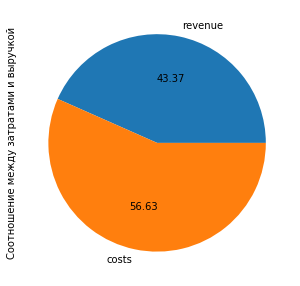

In [136]:
rev_costs.plot(y = 'sum', autopct='%.2f', kind = 'pie', figsize = (5, 5), legend = False)
plt.ylabel('Соотношение между затратами и выручкой')
plt.show()

Компания работает в убыток, по предоставленным данным

#### Анализ посещаемости ресурса по типу устройства.

In [137]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
visits_by_device

,uid
device,
desktop,262567
touch,96833


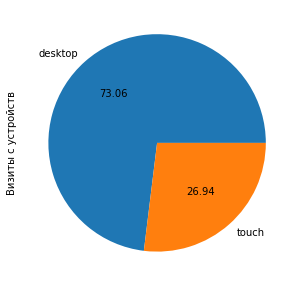

In [138]:
visits_by_device.plot(y = 'uid', autopct='%.2f', kind = 'pie', figsize = (5, 5), legend = False)
plt.ylabel('Визиты с устройств')
plt.show()


73 процента посещений совершаются с ПК и, соотвественно, 27 процентов с телефона.


## Общие выводы

1. По итогу можно сказать, что 1 и 2 каналы самый перспективный с точки зрения доходов, они привлекают таких клиентов, которые совершает большие покупки. В связи с этим, рекомендутся перераспределить вложения в рекламные каналы и с 3 канала часть средств направить на самые перспективные 1 и 2. Исходя из анализа LTV, CAC, ROMI самая прибыльная аудитория у 2-го иточника, самый дорогой канал рекламы - 3-й, самый большой канал по аудитории и с наименьшими затратами на привлечения 4-й канал.

2. Retention у Яндекс.Афиши очень низкий (около 3%). Большинство сессий имеют длительность не больше 1 минуты, то есть пользователи на ресурс и, сделав пару щелчков, выходят оттуда. Большая часть клиентов после первой покупки уже не возвращаются, а если и возвращаются, то делают не больше 2 покупок в месяц Оставшиеся же совершают в среднем 2 покупки в месяц. Средний чек 1 покупки - 6 у.е.

3. На фоне всех когорт особенно выделяется первая - её Retention заметно выше, чем у остальных когорт (6 процентных пунктов), и совершают больше покупок в месяц.
